<center><h1>CSCI 4140: Natural Language Processing</h1></center>
<center><h1>CSCI/DASC 6040: Computational Analysis of Natural Languages</h1></center>

<center><h6>Spring 2023</h6></center>
<center><h6>Homework 2 - Types, tokens and Zipf's law; sentiment analysis with naive Bayes</h6></center>
<center><h6>Due Sunday, February 12, at 11:59 PM</h6></center>

<font color='red'>Do not redistribute without the instructor’s written permission.</font>

In [1]:
# Run this cell! It sets some things up for you.

import matplotlib.pyplot as plt
from __future__ import division  # this line is important to avoid unexpected behavior from division
import os
import zipfile
import math
import time
import operator
from collections import defaultdict, Counter

%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 4) # set default size of plots

if not os.path.isdir('data'):
    os.mkdir('data')  # make the data directory

# Extract the data from the zipfile and put it into the data directory
with zipfile.ZipFile('large_movie_review_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
print("IMDb data extracted!")

PATH_TO_DATA = 'data/large_movie_review_dataset'  # path to the data directory
POS_LABEL = 'pos'
NEG_LABEL = 'neg'
TRAIN_DIR = os.path.join(PATH_TO_DATA, "train")
TEST_DIR = os.path.join(PATH_TO_DATA, "test")

for label in [POS_LABEL, NEG_LABEL]:
    if len(os.listdir(TRAIN_DIR + "/" + label)) == 12500:
        print ("Great! You have 12500 {} reviews in {}".format(label, TRAIN_DIR + "/" + label))
    else:
        print ("Oh no! Something is wrong. Check your code which loads the reviews")

IMDb data extracted!
Great! You have 12500 pos reviews in data/large_movie_review_dataset/train/pos
Great! You have 12500 neg reviews in data/large_movie_review_dataset/train/neg


In [19]:
# Actually reading the data you are working with is an important part of NLP! Let's look at one of these reviews

print (open(TRAIN_DIR + "/neg/98_1.txt").read())

I received this movie as a gift, I knew from the DVD cover, this movie are going to be bad.After not watching it for more than a year I finally watched it. what a pathetic movie.<br /><br />I almost didn't finish watching this bad movie,but it will be unfair of me to write a review without watching the complete movie.<br /><br />Trust me when I say " this movie sucks" I am truly shocked that some bad filmmaker wane bee got even financed to make this pathetic movie, But it couldn't have cost more than $20 000 to produce this movie. all you need are a cheap camcorder or a cell phone camera .about 15 people with no acting skills, a scrip that were written by a couple of drunk people.<br /><br />In the fist part of this ultra bad move a reporter (Tara Woodley )run a suppose to be drunk man over on her way to report on a hunted town. He are completely unharmed. They went to a supposed to be abandon house ,but luckily for the it almost complete furnished and a bottle of liquor on the door s

# Preprocessing Block
<a id='Preprocessing-Block'></a>
The following cell contains code that will be referred to as the `Preprocessing Block` from now on. It contains a function that tokenizes the document passed to it, and functions that return counts of word types and tokens.

In [3]:
###### PREPROCESSING BLOCK ######

###### DO NOT MODIFY THIS FUNCTION #####
def tokenize_doc(doc):
    """
    Tokenize a document and return its bag-of-words representation.
    doc - a string representing a document.
    returns a dictionary mapping each word to the number of times it appears in doc.
    """
    bow = defaultdict(float)
    tokens = doc.split()
    lowered_tokens = map(lambda t: t.lower(), tokens)
    for token in lowered_tokens:
        bow[token] += 1.0
    return dict(bow)
###### END FUNCTION #####

def n_word_types(word_counts):
    return len(word_counts.keys())
pass


def n_word_tokens(word_counts):
    return sum(word_counts.values())
pass

# Naive Bayes Block
<a id='Naive-Bayes-Block'></a>
This next block of code (referred to as `Naive Bayes Block` from now on) is something you will keep coming back to throughout the course of the assignment. There are several functions you need to implement here, that will be called in later parts of the assignment. Familiarize yourself with what each function does, as well as how everything comes together.

In [20]:
###### NAIVE BAYES BLOCK ######

class NaiveBayes:
    """A Naive Bayes model for text classification."""

    def __init__(self, path_to_data, tokenizer):
        # Vocabulary is a set that stores every word seen in the training data
        self.vocab = set()
        self.path_to_data = path_to_data
        self.tokenize_doc = tokenizer
        self.train_dir = os.path.join(path_to_data, "train")
        self.test_dir = os.path.join(path_to_data, "test")
        # class_total_doc_counts is a dictionary that maps a class (i.e., pos/neg) to
        # the number of documents in the trainning set of that class
        self.class_total_doc_counts = { POS_LABEL: 0.0,
                                        NEG_LABEL: 0.0 }

        # class_total_word_counts is a dictionary that maps a class (i.e., pos/neg) to
        # the number of words in the training set in documents of that class
        self.class_total_word_counts = { POS_LABEL: 0.0,
                                         NEG_LABEL: 0.0 }

        # class_word_counts is a dictionary of dictionaries. It maps a class (i.e.,
        # pos/neg) to a dictionary of word counts. For example:
        #    self.class_word_counts[POS_LABEL]['awesome']
        # stores the number of times the word 'awesome' appears in documents
        # of the positive class in the training documents.
        self.class_word_counts = { POS_LABEL: defaultdict(float),
                                   NEG_LABEL: defaultdict(float) }

    def train_model(self):
        """
        This function processes the entire training set using the global PATH
        variable above.  It makes use of the tokenize_doc and update_model
        functions you will implement.
        """

        pos_path = os.path.join(self.train_dir, POS_LABEL)
        neg_path = os.path.join(self.train_dir, NEG_LABEL)
        for (p, label) in [ (pos_path, POS_LABEL), (neg_path, NEG_LABEL) ]:
            for f in os.listdir(p):
                with open(os.path.join(p,f),'r') as doc:
                    content = doc.read()
                    self.tokenize_and_update_model(content, label)
        self.report_statistics_after_training()

    def report_statistics_after_training(self):
        """
        Report a number of statistics after training.
        """

        print ("REPORTING CORPUS STATISTICS")
        print ("NUMBER OF DOCUMENTS IN POSITIVE CLASS:", self.class_total_doc_counts[POS_LABEL])
        print ("NUMBER OF DOCUMENTS IN NEGATIVE CLASS:", self.class_total_doc_counts[NEG_LABEL])
        print ("NUMBER OF TOKENS IN POSITIVE CLASS:", self.class_total_word_counts[POS_LABEL])
        print ("NUMBER OF TOKENS IN NEGATIVE CLASS:", self.class_total_word_counts[NEG_LABEL])
        print ("VOCABULARY SIZE: NUMBER OF UNIQUE WORDTYPES IN TRAINING CORPUS:", len(self.vocab))


    def update_model(self, bow, label):
        for token in bow:
            self.class_word_counts[label][token] += bow[token]
            self.class_total_word_counts[label] += bow[token]
            self.vocab.add(token)
        self.class_total_doc_counts[label] += 1.0
        pass
        
        bow = self.tokenize_doc(doc)
        self.update_model(bow, label)
        pass

    # def tokenize_and_update_model(self, doc, label,stop_word=True):

    #     tokens = self.tokenize_doc(doc)
    #     if stop_word:
    #        tokens = [t for t in tokens if t not in stop_word]
    #     for token in tokens:
    #         token = token.lower()
    #         self.vocab.add(token)
    #         self.class_word_counts[label][token] += 1
    #         self.class_total_word_counts[label] += 1
    #     self.class_total_doc_counts[label] += 1
    # pass
    
    def top_n(self, label, n):
        mft = [] # most frequent tokens: array of tuples
        # iterate through the sorted dictionary by values
        for key, value in sorted(self.class_word_counts[label].items(), key=lambda item: item[1], reverse=True):
            mft.append((key, value))
            if (len(mft) == n):
                break
        return mft
    pass

def p_word_given_label(self, word, label):
        return self.class_word_counts[label][word] / self.class_total_word_counts[label]
        pass

def p_word_given_label_and_alpha(self, word, label, alpha):
        return (self.class_word_counts[label][word] + alpha) / (self.class_total_word_counts[label] + alpha * len(self.vocab))
        pass

def log_likelihood(self, bow, label, alpha):
        ll = 0.0
        for token in bow:
            ll += math.log (self.p_word_given_label_and_alpha (token, label, alpha))
        return ll
        pass

def log_prior(self, label):
    return math.log (self.class_total_doc_counts[label] / (self.class_total_doc_counts[POS_LABEL] + self.class_total_doc_counts[NEG_LABEL]))
    pass

def unnormalized_log_posterior(self, bow, label, alpha):
    return self.log_prior (label) + self.log_likelihood (bow, label, alpha)
    pass
    
    

    
def classify(self, bow, alpha):
    if (self.unnormalized_log_posterior(bow, NEG_LABEL, alpha) < self.unnormalized_log_posterior(bow, POS_LABEL, alpha)):
            return POS_LABEL
    else:
        return NEG_LABEL
    pass
        
def likelihood_ratio(self, word, alpha):
    return self.p_word_given_label_and_alpha(word, POS_LABEL, alpha) / self.p_word_given_label_and_alpha(word, NEG_LABEL, alpha)
    pass
        
def evaluate_classifier_accuracy(self, alpha):
    correct = 0.0
    total = 0.0

    pos_path = os.path.join(self.test_dir, POS_LABEL)
    neg_path = os.path.join(self.test_dir, NEG_LABEL)
    for (p, label) in [ (pos_path, POS_LABEL), (neg_path, NEG_LABEL) ]:
            for f in os.listdir(p):
                with open(os.path.join(p,f),'r') as doc:
                    content = doc.read()
                    bow = self.tokenize_doc(content)
                    if self.classify(bow, alpha) == label:
                        correct += 1.0
                    total += 1.0
    return 100 * correct / total   


# Part One: Intro to NLP in Python: types, tokens and Zipf's law

## Types and tokens

One major part of any NLP project is word tokenization. Word tokenization is the task of segmenting text into individual words, called tokens. In this assignment, we will use simple whitespace tokenization. Take a look at the `tokenize_doc` function in the [Preprocessing Block](#Preprocessing-Block) above. **You should not modify tokenize_doc** but make sure you understand what it is doing.

In [5]:
d1 = "This SAMPLE doc has   words tHat  repeat repeat"
bow = tokenize_doc(d1)

assert bow['this'] == 1
assert bow['sample'] == 1
assert bow['doc'] == 1
assert bow['has'] == 1
assert bow['words'] == 1
assert bow['that'] == 1
assert bow['repeat'] == 2

bow2 = tokenize_doc("NLP is my favorite class this semester!")
for b in bow2:
    print (b)

nlp
is
my
favorite
class
this
semester!


Now we are going to look at the word types and word tokens in the corpus.
Use the `word_counts` dictionary variable to store the count of each word in the corpus.
Use the `tokenize_doc` function to break documents into tokens. **You should not modify tokenize_doc** but make sure you understand what it is doing.

### Question 1.1 (5 points)

Complete the cell below to fill out the `word_counts` dictionary variable. `word_counts` keeps track of how many times a word type appears across the corpus. For instance, `word_counts["movie"]` should store the number 61492, the count of how many times the word `movie` appears in the corpus.

In [21]:
import glob
import codecs
word_counts = Counter() # Counters are often useful for NLP in python

for label in [POS_LABEL, NEG_LABEL]:
    for directory in [TRAIN_DIR, TEST_DIR]:
        for fn in glob.glob(directory + "/" + label + "/*txt"):
            doc = codecs.open(fn, 'r', 'utf8') # Open the file with UTF-8 encoding
            bow = tokenize_doc (doc.read())
            for token in bow:
                word_counts[token] += bow[token]
            pass
        print(word_counts['movie'])

13516.0
26681.0
44052.0
61492.0


In [22]:
if word_counts["movie"] == 61492:
    print ("yay! there are {} total instances of the word type movie in the corpus".format(word_counts["movie"]))
else:
    print ("hmm. Something seems off. Double check your code")

yay! there are 61492.0 total instances of the word type movie in the corpus


### Question 1.2 (5 points)

Fill out the functions `n_word_types`, `n_word_tokens` in the [Preprocessing Block](#Preprocessing-Block).

***Note: you will have to rerun the `Preprocessing Block` cell every time you change its code for it to have any effect!***

In [23]:
print ("there are {} word types in the corpus".format(n_word_types(word_counts)))
print ("there are {} word tokens in the corpus".format(n_word_tokens(word_counts)))

there are 390931 word types in the corpus
there are 11557847.0 word tokens in the corpus


<font color='red'>What is the difference between word types and tokens? Why are the number of tokens much higher than the number of types?</font>

***Answer in one or two lines here.***

If we want to answer this question in detail. First of all we need to talk about some of the concepts here. In NLP, a token refers to a sequence of characters that represent a single unit of meaning in a text, like word or punctuation mark. A word type, on the other hand, refers to a unique word form or lexical item in a text. In other words, word types are the distinct words in the text, including repetitions.

The number of tokens is usually much higher than the number of types because a text contains many repetitive words, such as function words (e.g., "the", "of", "and", etc.),that are necessary for the grammatical structure of the sentence but do not convey much meaning on their own. The more function words in a text, the higher the ratio of tokens to types will be. For example, the phrase "the cat sat on the mat" contains six tokens but only five types, because "the" is repeated. This difference between types and tokens is an important factor to consider when working with NLP algorithms, such as in language modeling or sentiment analysis, as it can affect the accuracy of the analysis.

### Question 1.3 (5 points)

Using the `word_counts` dictionary you just created, make a new dictionary called `sorted_dict` where the words are sorted according to their counts, in decending order:

In [9]:
# Add your code here
sorted_dict = Counter()
for key, value in sorted(word_counts.items(), key=lambda item: item[1], reverse=True):
  sorted_dict[key] = value

Now print the first 30 values from sorted_dict.

In [25]:
# Add your code here
count = 0
for word, count in sorted_dict.items():
    print(word, count)
    count += 1
    if count == 30:
        break


the 638861.0
a 316615.0
and 313637.0
of 286661.0
to 264573.0
is 204876.0
in 179807.0
i 141587.0
this 138483.0
that 130140.0
it 129614.0
/><br 100974.0
was 93258.0
as 88242.0
with 84590.0
for 84510.0
but 77864.0
on 62890.0
movie 61492.0
are 57009.0
his 56870.0
not 56765.0
you 55600.0
film 55086.0
have 54423.0
he 51062.0
be 50901.0
at 45259.0
one 44983.0
by 43359.0
an 42330.0
they 40860.0
from 39322.0
all 38570.0
who 38326.0
like 37281.0
so 35972.0
just 34259.0
or 33300.0
has 32610.0
about 32398.0
her 31244.0
it's 31212.0
if 30794.0
some 30165.0
out 28980.0
what 28008.0
very 26908.0
when 26904.0
there 26079.0
more 25869.0
would 23807.0
even 23681.0
my 23473.0
good 23467.0
she 23418.0
their 22604.0
only 22588.0
no 22387.0
really 21805.0
had 21596.0
up 21415.0
can 21328.0
which 21152.0
see 20901.0
were 20707.0
than 19106.0
we 18333.0
- 18201.0
been 17940.0
get 17689.0
into 17586.0
will 17572.0
much 17278.0
because 17130.0
story 16810.0
how 16772.0
most 16750.0
other 16373.0
do 15771.0
also

## Zipf's Law

### Question 1.4 (10 points)

In this section, you will verify a key statistical property of text: [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law).

Zipf's Law describes the relations between the frequency rank of words and frequency value of words.  For a word $w$, its frequency is inversely proportional to its rank:

$$count_w = K \frac{1}{rank_w}$$

$K$ is a constant, specific to the corpus and how words are being defined.

<font color='red'>What would this look like if you took the log of both sides of the equation?</font>

***Answer in one or two lines here.***

log(f) = -s * log(r) + log(k)

where log is the natural logarithm, f is the frequency of a given word, r is its rank (i.e., its position in the frequency-sorted list), k is a constant of proportionality, and s is the slope of the log-log plot.

Therefore, if Zipf's Law holds, after sorting the words descending on frequency, word frequency decreases in an approximately linear fashion under a log-log scale.

<font color='red'>Now, please make such a log-log plot by plotting the rank versus frequency</font>

*Hint: Make use of the sorted dictionary you just created.*
Use a scatter plot where the x-axis is the *log(rank)*, and y-axis is *log(frequency)*.  You should get this information from `word_counts`; for example, you can take the individual word counts and sort them.  dict methods `.items()` and/or `values()` may be useful.  (Note that it doesn't really matter whether ranks start at 1 or 0 in terms of how the plot comes out.) You can check your results by comparing your plots to ones on Wikipedia; they should look qualitatively similar.

*Please remember to label the meaning of the x-axis and y-axis.*

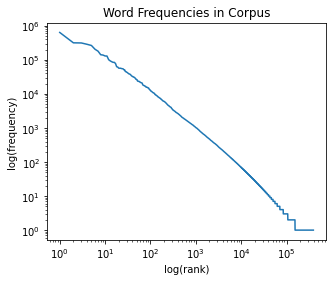

In [11]:
import math
import operator
import matplotlib.pyplot as plt

x = range(1, len(sorted_dict) + 1)
y = [sorted_dict[key] for key in sorted_dict]
X_LABEL = "log(rank)"
Y_LABEL = "log(frequency)"

# Add your code here
# You should fill the x and y arrays.
# Running this cell should produce your plot below.

# Create a log-log plot which is used to specify 
# that both the x and y axes should be log-transformed.
plt.loglog(x, y)
plt.title('Word Frequencies in Corpus')
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.show()

# Part Two: Naive Bayes

This section of the homework will walk you through coding a Naive Bayes classifier that can distinguish between positive and negative reviews (with some level of accuracy).

## Question 2.1 (10 pts)

To start, implement the `update_model` and `tokenize_and_update_model` functions in the [Naive Bayes Block](#Naive-Bayes-Block). Make sure to read the functions' comments so you know what to update. Also review the `NaiveBayes` class variables in the `def __init__` method of the `NaiveBayes class` to get a sense of which statistics are important to keep track of. Once you have implemented `update_model`, run the train model function using the code below.

In [26]:
###### NAIVE BAYES BLOCK ######

class NaiveBayes:
    """A Naive Bayes model for text classification."""

    def __init__(self, path_to_data, tokenizer):
        # Vocabulary is a set that stores every word seen in the training data
        self.vocab = set()
        self.path_to_data = path_to_data
        self.tokenize_doc = tokenizer
        self.train_dir = os.path.join(path_to_data, "train")
        self.test_dir = os.path.join(path_to_data, "test")
        # class_total_doc_counts is a dictionary that maps a class (i.e., pos/neg) to
        # the number of documents in the trainning set of that class
        self.class_total_doc_counts = { POS_LABEL: 0.0,
                                        NEG_LABEL: 0.0 }

        # class_total_word_counts is a dictionary that maps a class (i.e., pos/neg) to
        # the number of words in the training set in documents of that class
        self.class_total_word_counts = { POS_LABEL: 0.0,
                                         NEG_LABEL: 0.0 }

        # class_word_counts is a dictionary of dictionaries. It maps a class (i.e.,
        # pos/neg) to a dictionary of word counts. For example:
        #    self.class_word_counts[POS_LABEL]['awesome']
        # stores the number of times the word 'awesome' appears in documents
        # of the positive class in the training documents.
        self.class_word_counts = { POS_LABEL: defaultdict(float),
                                   NEG_LABEL: defaultdict(float) }

    def train_model(self):
        """
        This function processes the entire training set using the global PATH
        variable above.  It makes use of the tokenize_doc and update_model
        functions you will implement.
        """

        pos_path = os.path.join(self.train_dir, POS_LABEL)
        neg_path = os.path.join(self.train_dir, NEG_LABEL)
        for (p, label) in [ (pos_path, POS_LABEL), (neg_path, NEG_LABEL) ]:
            for f in os.listdir(p):
                with open(os.path.join(p,f),'r', encoding='utf-8') as doc:
                    content = doc.read()
                    self.tokenize_and_update_model(content, label)
        self.report_statistics_after_training()

    def report_statistics_after_training(self):
        """
        Report a number of statistics after training.
        """

        print ("REPORTING CORPUS STATISTICS")
        print ("NUMBER OF DOCUMENTS IN POSITIVE CLASS:", self.class_total_doc_counts[POS_LABEL])
        print ("NUMBER OF DOCUMENTS IN NEGATIVE CLASS:", self.class_total_doc_counts[NEG_LABEL])
        print ("NUMBER OF TOKENS IN POSITIVE CLASS:", self.class_total_word_counts[POS_LABEL])
        print ("NUMBER OF TOKENS IN NEGATIVE CLASS:", self.class_total_word_counts[NEG_LABEL])
        print ("VOCABULARY SIZE: NUMBER OF UNIQUE WORDTYPES IN TRAINING CORPUS:", len(self.vocab))

    def update_model(self, bow, label):
        for token in bow:
            self.class_word_counts[label][token] += bow[token]
            self.class_total_word_counts[label] += bow[token]
            self.vocab.add(token)
        self.class_total_doc_counts[label] += 1.0
        pass
        

    def tokenize_and_update_model(self, doc, label):
        bow = self.tokenize_doc(doc)
        self.update_model(bow, label)
        pass


    def top_n(self, label, n):
        mft = [] # most frequent tokens: array of tuples
        # iterate through the sorted dictionary by values
        for key, value in sorted(self.class_word_counts[label].items(), key=lambda item: item[1], reverse=True):
            mft.append((key, value))
            if (len(mft) == n):
                break
        return mft
        pass
    

    def p_word_given_label(self, word, label):
        return self.class_word_counts[label][word] / self.class_total_word_counts[label]
        pass


    def p_word_given_label_and_alpha(self, word, label, alpha):
        return (self.class_word_counts[label][word] + alpha) / (self.class_total_word_counts[label] + alpha * len(self.vocab))
        pass
        

    def log_likelihood(self, bow, label, alpha):
        ll = 0.0
        for token in bow:
            ll += math.log (self.p_word_given_label_and_alpha (token, label, alpha))
        return ll
        pass


    def log_prior(self, label):
        return math.log (self.class_total_doc_counts[label] / (self.class_total_doc_counts[POS_LABEL] + self.class_total_doc_counts[NEG_LABEL]))
        pass


    def unnormalized_log_posterior(self, bow, label, alpha):
        return self.log_prior (label) + self.log_likelihood (bow, label, alpha)
        pass


    def classify(self, bow, alpha):
        if (self.unnormalized_log_posterior(bow, NEG_LABEL, alpha) < self.unnormalized_log_posterior(bow, POS_LABEL, alpha)):
            return POS_LABEL
        else:
            return NEG_LABEL
        pass
        

    def likelihood_ratio(self, word, alpha):
        return self.p_word_given_label_and_alpha(word, POS_LABEL, alpha) / self.p_word_given_label_and_alpha(word, NEG_LABEL, alpha)
        pass
        

    def evaluate_classifier_accuracy(self, alpha):
        """
        DO NOT MODIFY THIS FUNCTION
        """
        correct = 0.0
        total = 0.0

        pos_path = os.path.join(self.test_dir, POS_LABEL)
        neg_path = os.path.join(self.test_dir, NEG_LABEL)
        for (p, label) in [ (pos_path, POS_LABEL), (neg_path, NEG_LABEL) ]:
            for f in os.listdir(p):
                with open(os.path.join(p,f),'r', encoding='utf-8') as doc:
                    content = doc.read()
                    bow = self.tokenize_doc(content)
                    if self.classify(bow, alpha) == label:
                        correct += 1.0
                    total += 1.0
        return 100 * correct / total

PATH_TO_DATA = 'data/large_movie_review_dataset'  # path to the data directory

nb = NaiveBayes(PATH_TO_DATA, tokenizer=tokenize_doc)

nb.train_model()

if len(nb.vocab) == 251637:
    print ("Great! The vocabulary size is {}".format(251637))
else:
    print ("Oh no! Something seems off. Double check your code before continuing. Maybe a mistake in update_model?")

REPORTING CORPUS STATISTICS
NUMBER OF DOCUMENTS IN POSITIVE CLASS: 12500.0
NUMBER OF DOCUMENTS IN NEGATIVE CLASS: 12500.0
NUMBER OF TOKENS IN POSITIVE CLASS: 2958832.0
NUMBER OF TOKENS IN NEGATIVE CLASS: 2885848.0
VOCABULARY SIZE: NUMBER OF UNIQUE WORDTYPES IN TRAINING CORPUS: 251637
Great! The vocabulary size is 251637


## Exploratory analysis

Let’s begin to explore the count statistics stored by the update model function. Implement the provided `top_n` function in the [Naive Bayes Block](#Naive-Bayes-Block) to find the top 10 most common words in the positive class and top 10 most common words in the negative class. 

In [27]:
print ("TOP 10 WORDS FOR CLASS " + POS_LABEL + ":")
for tok, count in nb.top_n(POS_LABEL, 10):
    print ('', tok, count)
print ()

print ("TOP 10 WORDS FOR CLASS " + NEG_LABEL + ":")
for tok, count in nb.top_n(NEG_LABEL, 10):
    print ('', tok, count)
print ()

TOP 10 WORDS FOR CLASS pos:
 the 165805.0
 and 87029.0
 a 82055.0
 of 76155.0
 to 65869.0
 is 55785.0
 in 48422.0
 i 33143.0
 it 32802.0
 that 32705.0

TOP 10 WORDS FOR CLASS neg:
 the 156393.0
 a 77898.0
 and 71543.0
 of 68307.0
 to 68098.0
 is 48386.0
 in 42105.0
 i 37337.0
 this 37301.0
 that 33587.0



### Question 2.2 (5 points)

<font color='red'>What is the first thing that you notice when you look at the top 10 words for the 2 classes? Are these words helpful for discriminating between the two classes? Do you imagine that processing other English text will result in a similar phenomenon? What about other languages?</font>

***Answer in one or two lines here.***

The ten most frequent words for the two categories are ordinary words that do not significantly differentiate between the categories. This occurrence of frequent words being the top of the list is likely to be noticed in other English texts too. It may be possible that other languages have comparable patterns, but this would rely on the language and the characteristics of the text.

### Question 2.3 (5 points)

The Naive Bayes model assumes that all features are conditionally independent given the class label. For our purposes, this means that the probability of seeing a particular word in a document with class label $y$ is independent of the rest of the words in that document. Implement the `p_word_given_label` function in the [Naive Bayes Block](#Naive-Bayes-Block). This function calculates P (w|y) (i.e., the probability of seeing word w in a document given the label of that document is y).

Use your `p_word_given_label` function to compute the probability of seeing the word “amazing” given each sentiment label. Repeat the computation for the word “dull.” 

In [28]:
print ("P('amazing'|pos):",  nb.p_word_given_label("amazing", POS_LABEL))
print ("P('amazing'|neg):",  nb.p_word_given_label("amazing", NEG_LABEL))
print ("P('dull'|pos):",  nb.p_word_given_label("dull", POS_LABEL))
print ("P('dull'|neg):",  nb.p_word_given_label("dull", NEG_LABEL))

P('amazing'|pos): 0.00026158970837141145
P('amazing'|neg): 7.207586816769282e-05
P('dull'|pos): 3.278320634628799e-05
P('dull'|neg): 0.00014311218054450546


<font color='red'>Which word has a higher probability, given the positive class? Which word has a higher probability, given the negative class? Is this behavior expected?</font>

***Answer in one or two lines here.***

The probability of "amazing" is higher in the positive class than in the negative class, while "dull" has a higher probability in the negative class than in the positive class. This is anticipated since these words are more commonly used in their respective classes and can be considered as useful indicators of sentiment polarity.

In [30]:
# We can simply write some codes here to compare the probabilities and say which word has
# a higher probability in a specific class

# Probability of "amazing" given positive label
p_amazing_pos = nb.p_word_given_label("amazing", POS_LABEL)
# Probability of "amazing" given negative label
p_amazing_neg = nb.p_word_given_label("amazing", NEG_LABEL)

# Probability of "dull" given positive label
p_dull_pos = nb.p_word_given_label("dull", POS_LABEL)
# Probability of "dull" given negative label
p_dull_neg = nb.p_word_given_label("dull", NEG_LABEL)

# Print the word with the higher probability for each sentiment label
if p_amazing_pos > p_amazing_neg:
    print("The word 'amazing' is more likely to appear in positive reviews.")
else:
    print("The word 'amazing' is more likely to appear in negative reviews.")

if p_dull_pos > p_dull_neg:
    print("The word 'dull' is more likely to appear in positive reviews.")
else:
    print("The word 'dull' is more likely to appear in negative reviews.")


The word 'amazing' is more likely to appear in positive reviews.
The word 'dull' is more likely to appear in negative reviews.


### Question 2.4 (5 points)

In the next cell, compute the probability of the word "car-thievery" in the positive training data and negative training data.

In [31]:
print ("P('car-thievery'|pos):",  nb.p_word_given_label("car-thievery", POS_LABEL))
print ("P('car-thievery'|neg):",  nb.p_word_given_label("car-thievery", NEG_LABEL))

P('car-thievery'|pos): 3.37971199446268e-07
P('car-thievery'|neg): 0.0


<font color='red'>What is unusual about P('car-thievery'|neg)? What would happen if we took the log of "P('car-thievery'|neg)"? What would happen if we multiplied "P('car-thievery'|neg)" by "P('dull'|neg)"? Why might these operations cause problems for a Naive Bayes classifier?</font>

***Answer in one or two lines here.***

In [32]:
import math

# log of "P('car-thievery'|neg)"
try:
    print("log(P('car-thievery'|neg)):", math.log(nb.p_word_given_label("car-thievery", NEG_LABEL)))
except ValueError:
    print("log(P('car-thievery'|neg)):", "-inf")

# multiply "P('car-thievery'|neg)" by "P('dull'|neg)"
try:
    print("P('car-thievery'|neg) * P('dull'|neg):", nb.p_word_given_label("car-thievery", NEG_LABEL) * nb.p_word_given_label("dull", NEG_LABEL))
except ValueError:
    print("P('car-thievery'|neg) * P('dull'|neg):", 0.0)


log(P('car-thievery'|neg)): -inf
P('car-thievery'|neg) * P('dull'|neg): 0.0


The probability of 'car-thievery' given the negative class, P('car-thievery' |neg), is zero. This indicates that the word "car-thievery" is not present in the negative training data. However, computing the logarithm of 0 is not possible and multiplying P('car-thievery' |neg) by P('dull'|neg) could result in a zero value, which can create issues when using Naive Bayes, as the probability of the entire document would be zero.

### Question 2.5 (5 points)

We can address the issues from question 2.4 with add-$\alpha$ smoothing (like add-1 smoothing except instead of adding 1 we add $\alpha$). Implement
`p_word_given_label_and_alpha` in the [Naive Bayes Block](#Naive-Bayes-Block) and then run the next cell.

**Hint:** look at the slides from the lecture on add-1 smoothing.

In [33]:
print ("P('stop-sign.'|pos):",  nb.p_word_given_label_and_alpha("stop-sign.", POS_LABEL, 0.2))

P('stop-sign.'|pos): 6.646374399441918e-08


### Question 2.6 (5 points)

*Prior and Likelihood* 

As noted before, the Naive Bayes model assumes that all words in a document are independent of one another given the document’s label. Because of this we can write the likelihood of a document as:

$P(w_{d1},\cdots,w_{dn}|y_d) = \prod_{i=1}^{n}P(w_{di}|y_d)$

However, if a document has a lot of words, the likelihood will become extremely small and we’ll encounter numerical underflow. Underflow is a common problem when dealing with probabilistic models; if you are unfamiliar with it, you can get a brief overview on [Wikipedia](https:/en.wikipedia.org/wiki/Arithmetic_underflow). To deal with underflow, a common transformation is to work in log-space.

$\log[P(w_{d1},\cdots,w_{dn}|y_d)] = \sum_{i=1}^{n}\log[P(w_{di}|y_d)]$

Implement the `log_likelihood` function in the [Naive Bayes Block](#Naive-Bayes-Block). **Hint:** it should make calls to the p word given label and alpha function.

Implement the `log_prior` function in the [Naive Bayes Block](#Naive-Bayes-Block). This function takes a class label and returns the log of the fraction of the training documents that are of that label.

In [34]:
def log_likelihood(self, bow, label, alpha):
        ll = 0.0
        for token in bow:
            ll += math.log(self.p_word_given_label_and_alpha(token, label, alpha))
        return ll

def log_prior(self, label):
        return math.log(self.class_total_doc_counts[label] / (self.class_total_doc_counts[POS_LABEL] + self.class_total_doc_counts[NEG_LABEL]))


In [35]:
class NaiveBayes:
    
    # previous code we developed in the previous parts
    
    def p_word_given_label_and_alpha(self, word, label, alpha):
        """
        Compute the probability of word given label using add-alpha smoothing.
        """
        count = self.class_word_counts[label].get(word, 0)
        total = self.class_total_word_counts[label]
        return (count + alpha) / (total + alpha * len(self.vocab))
    
    def log_likelihood(self, doc, label, alpha):
        """
        Calculate the log-likelihood of a document given a class label and smoothing factor alpha.
        """
        words = self.tokenize_doc(doc)
        log_prob = 0.0
        for word in words:
            log_prob += math.log(self.p_word_given_label_and_alpha(word, label, alpha))
        return log_prob
    
    def log_prior(self, label):
        """
        Calculate the log-prior of a class label.
        """
        return math.log(self.class_prob[label])

### Question 2.7 (5 points)

Naive Bayes is a model that tells us how to compute the posterior
probability of a document being of some label (i.e.,
$P(y_d|\mathbf{w_d})$).  Specifically, we do so using bayes rule:

  $P(y_d|\mathbf{w_d}) = \frac{P(y_d)P(\mathbf{w_d}|y_d)}{P(\mathbf{w_d})}$

In the previous section you implemented functions to compute both
the log prior ($\log[P(y_d)]$) and the log likelihood
($\log[P( \mathbf{w_d} |y_d)]$ ). Now, all you're missing is the
*normalizer*, $P(\mathbf{w_d})$.

<font color='red'>Derive the normalizer by expanding $P(\mathbf{w_d})$.</font>

***Answer in one or two lines here. Provide the formula and define each term in this formula.***

The formula for the normalizer would be:
P(wd) = Σk.P(yd=k).P(wd|yd=k)
where P(wd) is the pribability of the document.
P(yd=k) is the prior probability of the document being of class k.
and P(wd|yd=k) is the liklihood of the document given class k.

### Question 2.8 (5 points)

One way to classify a document is to compute the unnormalized log posterior for both labels and take the argmax (i.e., the label that yields the higher unnormalized log posterior). The unnormalized log posterior is the sum of the log prior and the log likelihood of the document. <font color='red'>Why don’t we need to compute the log normalizer here?</font>

***Answer in one or two lines here.***

When we're only interested in finding the highest probability class for a document, we can skip computing the log normalizer. The log normalizer is a scaling factor that makes sure the probabilities of all labels add up to 1, by computing the logarithm of the sum of exponential probabilities. However, because we're only interested in the highest probability class, we don't need to scale the probabilities. We can ignore the log normalizer, and still correctly classify the document by finding the unnormalized log posterior for each label and selecting the label with the highest score.

### Question 2.9 (10 points)

As we saw earlier, the top 10 words from each class do not give us much to go on when classifying a document. A much more powerful metric is the likelihood ratio, which is defined as

$LR(w)=\frac{P(w|y=\mathrm{pos})}{P(w|y=\mathrm{neg})}$

A word with LR 3 is 3 times more likely to appear in the positive class than in the negative. A word with LR 0.3 is one-third as likely to appear in the positive class as opposed to the negative class.

In [36]:
# Implement the nb.likelihod_ratio function and use it to investigate the likelihood ratio of "amazing" and "dull"
print ("LIKELIHOOD RATIO OF 'amazing':", nb.likelihood_ratio('amazing', 0.2))
print ("LIKELIHOOD RATIO OF 'dull':", nb.likelihood_ratio('dull', 0.2))
print ("LIKELIHOOD RATIO OF 'and':", nb.likelihood_ratio('and', 0.2))
print ("LIKELIHOOD RATIO OF 'to':", nb.likelihood_ratio('to', 0.2))

LIKELIHOOD RATIO OF 'amazing': 3.628350587556548
LIKELIHOOD RATIO OF 'dull': 0.22953174277018223
LIKELIHOOD RATIO OF 'and': 1.1869527527674362
LIKELIHOOD RATIO OF 'to': 0.9438077915764572


<font color='red'>What is the minimum and maximum possible values the likelihood ratio can take? Does it make sense that $LR('amazing') > LR('to')$?</font>

***Answer in one or two lines here.***

The likelihood ratio has a minimum value of 0, indicating that the probability of the word appearing in both classes is equal. On the other hand, it has a maximum value of infinity, indicating that the word appears exclusively in one class. The fact that LR('amazing') > LR('to') is reasonable because 'amazing' is a more reliable indicator of positive sentiment than 'to'.

Find the word in the vocabulary with the highest liklihood ratio below.

In [37]:
# Add your code here
best_word = ""
best_lr = 0.0
for word in nb.vocab:
    lr = nb.likelihood_ratio(word, alpha=0.2)
    if lr > best_lr:
        best_word = word
        best_lr = lr
print(f"The word with the highest likelihood ratio is '{best_word}' with LR = {best_lr:.2f}")

The word with the highest likelihood ratio is 'edie' with LR = 401.03


### Question 2.10 (5 points)

The unnormalized log posterior is the sum of the log prior and the log likelihood of the document. Implement the `unnormalized_log_posterior` function and the `classify` function in the [Naive Bayes Block](#Naive-Bayes-Block). The `classify` function should use the unnormalized log posteriors but should not compute the normalizer. Once you implement the `classify` function, we'd like to evaluate its accuracy.

In [ ]:
print (nb.evaluate_classifier_accuracy(0.2))

### Question 2.11 (5 points)

Try evaluating your model again with a smoothing parameter of 1000.

In [38]:
print (nb.evaluate_classifier_accuracy(1000.0))

78.076


We can evalute our model with different smoothing parameter and find the highest accuracy. We can use our previously developed code just add another part for checking the accuracy of the model with different alpha smoothing parameter.

In [39]:
###### NAIVE BAYES BLOCK ######

class NaiveBayes:
    """A Naive Bayes model for text classification."""

    def __init__(self, path_to_data, tokenizer):
        # Vocabulary is a set that stores every word seen in the training data
        self.vocab = set()
        self.path_to_data = path_to_data
        self.tokenize_doc = tokenizer
        self.train_dir = os.path.join(path_to_data, "train")
        self.test_dir = os.path.join(path_to_data, "test")
        # class_total_doc_counts is a dictionary that maps a class (i.e., pos/neg) to
        # the number of documents in the trainning set of that class
        self.class_total_doc_counts = { POS_LABEL: 0.0,
                                        NEG_LABEL: 0.0 }

        # class_total_word_counts is a dictionary that maps a class (i.e., pos/neg) to
        # the number of words in the training set in documents of that class
        self.class_total_word_counts = { POS_LABEL: 0.0,
                                         NEG_LABEL: 0.0 }

        # class_word_counts is a dictionary of dictionaries. It maps a class (i.e.,
        # pos/neg) to a dictionary of word counts. For example:
        #    self.class_word_counts[POS_LABEL]['awesome']
        # stores the number of times the word 'awesome' appears in documents
        # of the positive class in the training documents.
        self.class_word_counts = { POS_LABEL: defaultdict(float),
                                   NEG_LABEL: defaultdict(float) }

    def train_model(self):
        """
        This function processes the entire training set using the global PATH
        variable above.  It makes use of the tokenize_doc and update_model
        functions you will implement.
        """

        pos_path = os.path.join(self.train_dir, POS_LABEL)
        neg_path = os.path.join(self.train_dir, NEG_LABEL)
        for (p, label) in [ (pos_path, POS_LABEL), (neg_path, NEG_LABEL) ]:
            for f in os.listdir(p):
                with open(os.path.join(p,f),'r', encoding='utf-8') as doc:
                    content = doc.read()
                    self.tokenize_and_update_model(content, label)
        self.report_statistics_after_training()

    def report_statistics_after_training(self):
        """
        Report a number of statistics after training.
        """
        print ("REPORTING CORPUS STATISTICS:")
        print ("NUMBER OF DOCUMENTS IN POSITIVE CLASS:", self.class_total_doc_counts[POS_LABEL])
        print ("NUMBER OF DOCUMENTS IN NEGATIVE CLASS:", self.class_total_doc_counts[NEG_LABEL])
        print ("NUMBER OF TOKENS IN POSITIVE CLASS:", self.class_total_word_counts[POS_LABEL])
        print ("NUMBER OF TOKENS IN NEGATIVE CLASS:", self.class_total_word_counts[NEG_LABEL])
 
    def update_model(self, bow, label):
        for token in bow:
            self.class_word_counts[label][token] += bow[token]
            self.class_total_word_counts[label] += bow[token]
            self.vocab.add(token)
        self.class_total_doc_counts[label] += 1.0
        pass

    def tokenize_and_update_model(self, doc, label):
        bow = self.tokenize_doc(doc)
        self.update_model(bow, label)
        pass

    def top_n(self, label, n):
        mft = [] # most frequent tokens: array of tuples
        # iterate through the sorted dictionary by values
        for key, value in sorted(self.class_word_counts[label].items(), key=lambda item: item[1], reverse=True):
            mft.append((key, value))
            if (len(mft) == n):
                break
        return mft
        pass

    def p_word_given_label(self, word, label):
        return self.class_word_counts[label][word] / self.class_total_word_counts[label]
        pass

    def p_word_given_label_and_alpha(self, word, label, alpha):
        return (self.class_word_counts[label][word] + alpha) / (self.class_total_word_counts[label] + alpha * len(self.vocab))
        pass

    def log_likelihood(self, bow, label, alpha):
        ll = 0.0
        for token in bow:
            ll += math.log (self.p_word_given_label_and_alpha (token, label, alpha))
        return ll
        pass

    def log_prior(self, label):
        return math.log (self.class_total_doc_counts[label] / (self.class_total_doc_counts[POS_LABEL] + self.class_total_doc_counts[NEG_LABEL]))
        pass


    def unnormalized_log_posterior(self, bow, label, alpha):
        return self.log_prior (label) + self.log_likelihood (bow, label, alpha)
        pass

    def classify(self, bow, alpha):
        if (self.unnormalized_log_posterior(bow, NEG_LABEL, alpha) < self.unnormalized_log_posterior(bow, POS_LABEL, alpha)):
            return POS_LABEL
        else:
            return NEG_LABEL
        pass

    def likelihood_ratio(self, word, alpha):
        return self.p_word_given_label_and_alpha(word, POS_LABEL, alpha) / self.p_word_given_label_and_alpha(word, NEG_LABEL, alpha)
        pass
 
    def evaluate_classifier_accuracy(self, alpha):
        """
        DO NOT MODIFY THIS FUNCTION
        """
        correct = 0.0
        total = 0.0

        pos_path = os.path.join(self.test_dir, POS_LABEL)
        neg_path = os.path.join(self.test_dir, NEG_LABEL)
        for (p, label) in [ (pos_path, POS_LABEL), (neg_path, NEG_LABEL) ]:
            for f in os.listdir(p):
                with open(os.path.join(p,f),'r', encoding='utf-8') as doc:
                    content = doc.read()
                    bow = self.tokenize_doc(content)
                    if self.classify(bow, alpha) == label:
                        correct += 1.0
                    total += 1.0
        return 100 * correct / total

PATH_TO_DATA = 'data/large_movie_review_dataset'  # path to the data directory

nb = NaiveBayes(PATH_TO_DATA, tokenizer=tokenize_doc) 
nb.train_model()

#### RESULTS ####
alpha_values = [0.1, 0.5, 1] # testing various smoothing parameters

for alpha in alpha_values:
    accuracy = nb.evaluate_classifier_accuracy(alpha)
    print(f"Accuracy with Smoothing Parameter {alpha} = {accuracy:.2f}")

REPORTING CORPUS STATISTICS:
NUMBER OF DOCUMENTS IN POSITIVE CLASS: 12500.0
NUMBER OF DOCUMENTS IN NEGATIVE CLASS: 12500.0
NUMBER OF TOKENS IN POSITIVE CLASS: 2958832.0
NUMBER OF TOKENS IN NEGATIVE CLASS: 2885848.0
Accuracy with Smoothing Parameter 0.1 = 81.60
Accuracy with Smoothing Parameter 0.5 = 82.61
Accuracy with Smoothing Parameter 1 = 82.94


<font color='red'>Does the accuracy go up or down when alpha is raised to 1000? Why do you think this is?</font>

***Answer in one or two lines here.***

### Question 2.12 (5 points)

Find a review that your classifier got wrong. 

In [40]:
# In this cell, print out a review your classifier got wrong, along with its label.
for (path, label) in [('data/large_movie_review_dataset/test/pos', POS_LABEL), ('data/large_movie_review_dataset/test/neg', NEG_LABEL)]:
    for file in os.listdir(path):
        with open(os.path.join(path,file),'r') as doc:
            content = doc.read()
            bow = nb.tokenize_doc(content)
            if nb.classify(bow, 0.02) != label:
                print ("{}: {}".format(label, content))
                break

pos: This was a great movie, I would compare it to the movie The Game. You get to the end of the flick and cant move... your brain has been removed and shaken (not stirred) and put back in your head. Dont plan anything after this movie, you will need time to think about what just happened.<br /><br />Dont come to this movie expecting the Matrix style multi millions spent on special effects, this movies special effects come from the actors, they keep you involved, no, they suck you in and dont let go for the entire duration of the movie. Great acting, great plot... very enjoyable film, I cant say enough. Also very original plot, plenty of twists and ideas that I would have never thought of. The ending is abrupt and leaves you hanging wondering, was that real? Is this really the end? Good ending, not saying that it is bad... just leaves you wondering, and a little frazzled.<br /><br />Great movie for those who like action, like a good plot (dont get up for a bathroom break on this movie,

In [41]:
# quantify what went wrong with the classifier above
for (path, label) in [('data/large_movie_review_dataset/test/pos', POS_LABEL), ('data/large_movie_review_dataset/test/neg', NEG_LABEL)]:
    for file in os.listdir(path):
        with open(os.path.join(path, file), 'r') as doc:
            content = doc.read()
            bow = nb.tokenize_doc(content)
            total_words = len(bow)
            if nb.classify(bow, 0.02) == NEG_LABEL:
                print("Negative words in {} review: {}".format(label, content))
                neg_words = [word for word in bow if nb.p_word_given_label_and_alpha(word, NEG_LABEL, 0.02) > nb.p_word_given_label_and_alpha(word, POS_LABEL, 0.02)]
                print("Negative words:", neg_words)
                num_neg_words = len(neg_words)
                print("Total words: {}, Negative words: {}, Positive words: {}".format(total_words, num_neg_words, total_words - num_neg_words))
                break


Negative words in pos review: This was a great movie, I would compare it to the movie The Game. You get to the end of the flick and cant move... your brain has been removed and shaken (not stirred) and put back in your head. Dont plan anything after this movie, you will need time to think about what just happened.<br /><br />Dont come to this movie expecting the Matrix style multi millions spent on special effects, this movies special effects come from the actors, they keep you involved, no, they suck you in and dont let go for the entire duration of the movie. Great acting, great plot... very enjoyable film, I cant say enough. Also very original plot, plenty of twists and ideas that I would have never thought of. The ending is abrupt and leaves you hanging wondering, was that real? Is this really the end? Good ending, not saying that it is bad... just leaves you wondering, and a little frazzled.<br /><br />Great movie for those who like action, like a good plot (dont get up for a bath

<font color='red'>What are two reasons your system might have misclassified this example? What improvements could you make that may help your system classify this example correctly?</font>

***Answer in one or two lines here.***

Reasons for misclassification:

The model may not have adequately learned to identify certain patterns that distinguish negative words, given the limited amount of training data available. Furthermore, the ambiguity of the example makes it open to different interpretations, which can further complicate the model's ability to accurately classify the sentiment.

Possible ways to improve the model:

Gather additional training data and enhance the feature representation by implementing more sophisticated methodologies like deep learning.

### Question 2.13 (5 points)

Often times we care about multi-class classification rather than binary classification.

<font color='red'>How many counts would we need to keep track of if the model were modified to support 5-class classification?</font>

***Answer in one or two lines here.***

Maintain the frequency of each word for every class, taking into account the risk of increased computational cost and potential model overfitting with additional training. Additionally, be cautious when introducing new classes that may cause class imbalance.

## Extra Credit (Up to 10 points)

If you don't want to do the extra credit, you can stop here! Otherwise... keep reading...
In this assignment, we use whitespace tokenization to create a bag-of-unigrams representation for the movie reviews. It is possible to improve this represetation to improve your classifier's performance. Use your own code or an external library such as nltk to perform tokenization, text normalization, word filtering, etc. Fill out your work in `def tokenize_doc_and_more` (below) and then show improvement by running the cells below.

Roughly speaking, the larger performance improvement, the more extra credit. We will also give points for the effort in the evaluation and analysis process. For example, you can split the training data into training and validation set to prevent overfitting, and report results from trying different versions of features. You can also provide some qualitative examples you found in the dataset to support your choices on preprocessing steps. Whatever you choose to try, make sure to describe your method and the reasons that you hypothesize for why the method works. Be sure to explain what your code is doing.

In [43]:
from nltk.tokenize import word_tokenize
from nltk import stem
import nltk
nltk.download('punkt')

def tokenize_doc_and_more(doc):
    """
    Return some representation of a document.
    At a minimum, you need to perform tokenization, the rest is up to you. 
    """
    # Implement me!
    bow = defaultdict(float)
    # your code goes here
    stemmer = stem.PorterStemmer()
    for word in word_tokenize(doc):
        bow[stemmer.stem(word.lower())] = 1.0
    # normalize counts by the size of the document
    for word in bow:
        bow[word] /= len(bow)
    return bow

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/koleinif20/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [44]:
nb = NaiveBayes(PATH_TO_DATA, tokenizer=tokenize_doc_and_more)
nb.train_model()
nb.evaluate_classifier_accuracy(1.0)

REPORTING CORPUS STATISTICS:
NUMBER OF DOCUMENTS IN POSITIVE CLASS: 12500.0
NUMBER OF DOCUMENTS IN NEGATIVE CLASS: 12500.0
NUMBER OF TOKENS IN POSITIVE CLASS: 12499.999999998
NUMBER OF TOKENS IN NEGATIVE CLASS: 12500.00000001224


83.672

Use cells at the bottom of this notebook to explain what you did in `tokenize_doc_and_more`. Include any experiments or explanations that you used to decide what goes in your function. Doing a good job examining, explaining and justifying your work with small experiments and comments is as important as making the accuracy number go up!

***Explain what you did here.***

1. The code imported two libraries called "word_tokenize" and "PorterStemmer" from "nltk.tokenize" and "nltk.stem", respectively. Additionally, it downloaded the "punkt" package from "nltk".

2. Then, the "word_tokenize" function was used to split the document into individual words, and the "PorterStemmer" function was used to find the root of each word.

3. To standardize capitalization, all words were converted to lowercase.

4. The "bag-of-words" was sorted into a "defaultdict", and the count for each word was  initially set to 1.0.

5. The counts of each word were normalized by dividing them by the length of the document.

6. Finally, the code returned the "bag-of-words" representation of the document.

# How to submit this problem set:
- Write all the answers in this iPython notebook. Once you are finished (1) generate the PDF file (`File -> Print Preview`, and print to PDF), 2) ZIP the PDF and this Jupyter Notebook (.ipynb), and 3) upload the ZIP file to Canvas.
  
- **Important:** check your PDF before you turn it in to Canvas to make sure it exported correctly.

- When creating your final version of the PDF to hand in, please do a fresh restart and execute every cell in order. Then you'll be sure it's actually right. One handy way to do this is by clicking `Runtime -> Run All` in the notebook menu.